In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import cv2
import sys
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio


In [2]:
from IPython import display

In [3]:
keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string)
}

def parser(record):
    
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    
    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive}

<BatchDataset shapes: {imageNeutral: (None, 224, 224, 1), imageExpressive: (None, 224, 224, 1)}, types: {imageNeutral: tf.float32, imageExpressive: tf.float32}>


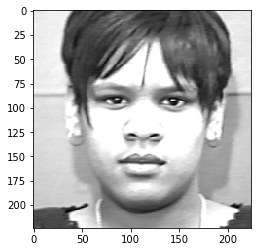

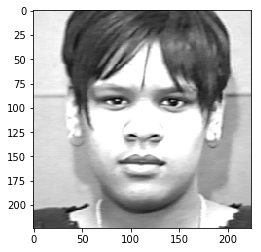

In [18]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 100

DB_PATH = 'C:\\Users\\Will\\Documents\\StoicNetData\\'

raw_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_val = tf.data.TFRecordDataset(DB_PATH + "val.tfrecords")
raw_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

parsed_train = raw_train.map(parser).shuffle(1000).batch(BATCH_SIZE)
parsed_val = raw_val.map(parser).shuffle(1000).batch(BATCH_SIZE)
parsed_test = raw_test.map(parser).shuffle(1000).batch(BATCH_SIZE)
print(parsed_train)

for image_features in parsed_train.take(1):
    image_raw = image_features['imageNeutral'].numpy()
    plt.imshow(np.squeeze(image_raw[0,:,:,:]), cmap='gray', vmin=0, vmax=255)
    plt.show()
    image_raw = image_features['imageExpressive'].numpy()
    plt.imshow(np.squeeze(image_raw[0,:,:,:]), cmap='gray', vmin=0, vmax=255)
    plt.show()

In [19]:
class VAEGAN(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ], name="encoder")
        
        self.generator = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=3, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(2, 2), padding="SAME", use_bias=False,
                activation='tanh'),
        ], name="generator")
    
    @tf.function
    def sample(self, epsilon=None):
        if epsilon is None:
            epsilon = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(epsilon, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        # Logvar used for numerical stability
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generator(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [20]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

# Single sample Monte Carlo estimate
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    # Watch any trainable variables for automatic differentiation
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [21]:
epochs = 100
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = VAEGAN(100)

In [22]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

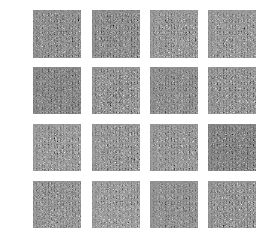

SHAPE: (100, 224, 224, 1)
SHAPE: (100, 224, 224, 1)
SHAPE: (100, 224, 224, 1)
SHAPE: (100, 224, 224, 1)
SHAPE: (100, 224, 224, 1)
SHAPE: (100, 224, 224, 1)
SHAPE: (100, 224, 224, 1)


In [ ]:
# Save image for pre-training
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs+1):
    start_time = time.time()
    
    for image_features in parsed_train:
        neutral_raw = image_features['imageNeutral'].numpy()
        print("SHAPE: {0}".format(neutral_raw.shape))
        compute_apply_gradients(model, neutral_raw, optimizer)
        
        expressive_raw = image_features['imageExpressive'].numpy()
        compute_apply_gradients(model, expressive_raw, optimizer)

    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in parsed_test:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
            'time elapse for current epoch {}'.format(
                epoch, elbo, end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)
            